In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Type
from planning.map.type import Coor
from planning.map import BuildingMap, BuildingMapGenConfig
from planning.scenarios import ScenarioConfig, Scenario, ScenarioSize
from planning.map.util import manhattan_distance, euclidean_distance, clip
from planning.planner import AStarPlanner, DijkstraPlanner, DFSPlanner, RRTPlanner, RRTStarPlanner, Planner
from planning.experiment import run_planner

In [2]:
sns.set_style("darkgrid")

# Benchmark

In [3]:
def run_seeds(n_seed: int, scenario_size: ScenarioSize):
    benchmark_results = []
    pbar = tqdm(total=n_seed * 5)
    for seed in range(n_seed):
        bmap, src, target = Scenario.get(seed, scenario_size)
        astar_planner = AStarPlanner(bmap)
        dijkstra_planner = DijkstraPlanner(bmap)
        dfs_planner = DFSPlanner(bmap)
        # RRT specific
        max_streering_radius = clip(bmap.shape[0] // 20, 2, 10)
        destination_reached_radius = clip(bmap.shape[0] // 25, 5, 8)
        neighbor_radius = clip(bmap.shape[0]//25, 5, 8)
        rrt_max_step = bmap.shape[0] * 50
        rrt_planner = RRTPlanner(bmap, max_streering_radius = max_streering_radius, max_steps = rrt_max_step, destination_reached_radius = destination_reached_radius)
        rrt_star_planner = RRTStarPlanner(bmap, max_streering_radius = max_streering_radius, max_steps = rrt_max_step, 
                                            destination_reached_radius = destination_reached_radius, neighbor_radius = neighbor_radius, quit_early = False)
        for planner in [astar_planner, dijkstra_planner, dfs_planner, rrt_planner, rrt_star_planner]:
            pbar.set_postfix({"seed": seed, "planner": planner.__class__.__name__})
            benchmark_results.append(run_planner(bmap, planner, src, target, seed))
            pbar.update()
    return pd.DataFrame(benchmark_results)


## Small Map

In [4]:
xs_df = run_seeds(5, scenario_size=ScenarioSize.XS)
s_df = run_seeds(5, scenario_size=ScenarioSize.S)
m_df = run_seeds(5, scenario_size=ScenarioSize.M)

100%|██████████| 25/25 [00:45<00:00,  1.81s/it, seed=4, planner=RRTStarPlanner] 


In [5]:
l_df = run_seeds(5, scenario_size=ScenarioSize.L)

100%|██████████| 25/25 [02:16<00:00,  5.44s/it, seed=4, planner=RRTStarPlanner] 


In [6]:
xl_df = run_seeds(5, scenario_size=ScenarioSize.XL)

100%|██████████| 25/25 [09:19<00:00, 22.37s/it, seed=4, planner=RRTStarPlanner] 


In [41]:
xs_mean_df = xs_df.groupby('planner').mean()
xs_mean_df['size'] = 'xs'
s_mean_df = s_df.groupby('planner').mean()
s_mean_df['size'] = 's'
m_mean_df = m_df.groupby('planner').mean()
m_mean_df['size'] = 'm'
l_mean_df = l_df.groupby('planner').mean()
l_mean_df['size'] = 'l'
xl_mean_df = xl_df.groupby('planner').mean()
xl_mean_df['size'] = 'xl'
merged_agg_df = pd.concat([xs_mean_df, s_mean_df, m_mean_df, l_mean_df, xl_mean_df]).reset_index()

Text(0.5, 1.0, 'Log Path Length vs Map Size')

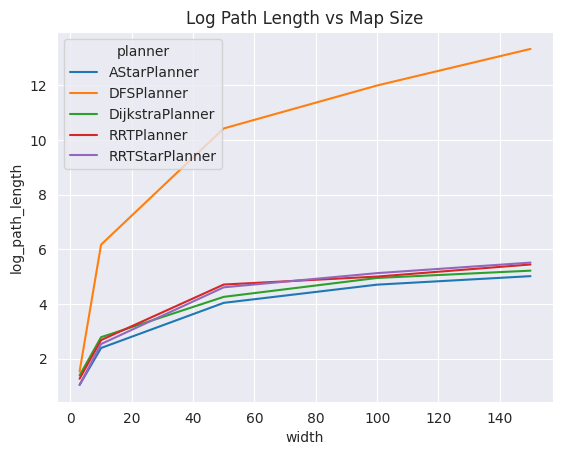

In [42]:
merged_agg_df['log_path_length'] = np.log(merged_agg_df['path_length'])
sns.lineplot(data=merged_agg_df, x='width', y='log_path_length', hue='planner')
plt.title("Log Path Length vs Map Size")

Text(0.5, 1.0, 'Path Length vs Map Size')

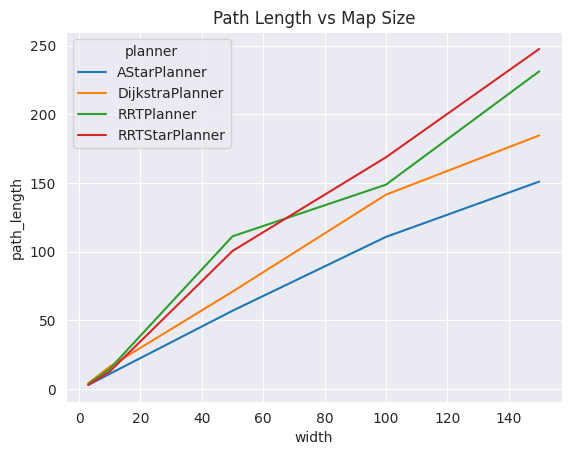

In [45]:
no_dfs = merged_agg_df[merged_agg_df['planner'] != 'DFSPlanner']
sns.lineplot(data=no_dfs, x='width', y='path_length', hue='planner')
plt.title("Path Length vs Map Size")

Text(0.5, 1.0, 'Time Taken vs Map Size')

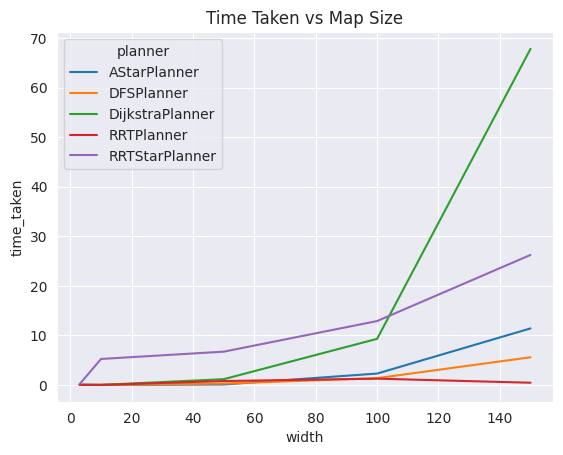

In [30]:
sns.lineplot(data=merged_agg_df, x='width', y='time_taken', hue='planner')
plt.title("Time Taken vs Map Size")

Text(0.5, 1.0, '# Visited vs Map Size')

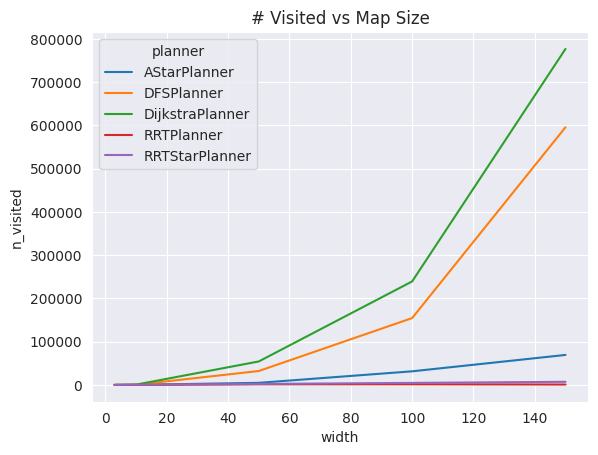

In [50]:
sns.lineplot(data=merged_agg_df, x='width', y='n_visited', hue='planner')
plt.title("# Visited vs Map Size")
# merged_agg_df

Text(0.5, 1.0, 'Visited Ratio vs Map Size')

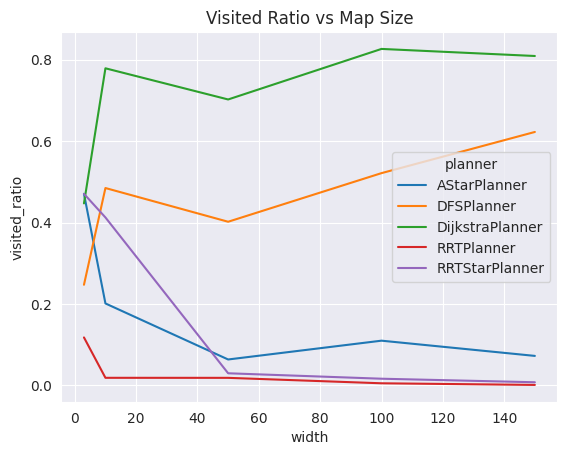

In [52]:
sns.lineplot(data=merged_agg_df, x='width', y='visited_ratio', hue='planner')
plt.title("Visited Ratio vs Map Size")
# merged_agg_df

# Time Complexity Growth

In [9]:
def time_planner(n_seed: int, sizes: List[int], planner_class: Type[Planner]):
    result = []
    pbar = tqdm(total=n_seed * len(sizes))
    for seed in range(n_seed):
        np.random.seed(n_seed)
        for size in sizes:
            pbar.set_postfix({"Seed": seed, "Size": size})
            config = BuildingMapGenConfig(width1=size, width2=size, height=size, n_building=size // 2,
                                          min_building_size=size // 4,
                                          max_building_size=size // 2, max_building_height=size,
                                          sample_point_max_height=2)
            bmap, src, target = Scenario.get_with_config(config)
            planner = planner_class(bmap)
            if planner_class == RRTStarPlanner or planner_class == RRTPlanner:
                max_streering_radius = clip(bmap.shape[0] // 20, 2, 10)
                destination_reached_radius = clip(bmap.shape[0] // 25, 5, 8)
                neighbor_radius = clip(bmap.shape[0]//25, 5, 8)
                rrt_max_step = bmap.shape[0] * 70
                planner = planner_class(bmap, max_steps=rrt_max_step, max_streering_radius=max_streering_radius,
                                    destination_reached_radius=destination_reached_radius)
            solved, visited, path = planner.plan(src, target)
            result.append(run_planner(bmap, planner, src, target, seed))
            pbar.update()
    return pd.DataFrame(result)

sizes = [10, 20, 40, 60, 80, 100]
# astar_time_df = time_planner(20, sizes=sizes, planner_class=AStarPlanner)
# dijkstra_time_df = time_planner(20, sizes=sizes, planner_class=DijkstraPlanner)
# dfs_time_df = time_planner(20, sizes=sizes, planner_class=DFSPlanner)
rrt_time_df = time_planner(20, sizes=sizes, planner_class=RRTPlanner)
rrt_star_time_df = time_planner(20, sizes=sizes, planner_class=RRTStarPlanner)

100%|██████████| 120/120 [27:26<00:00, 13.72s/it, Seed=19, Size=100]


/tmp/ipykernel_358217/1792579725.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = astar_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Time Taken (s)')

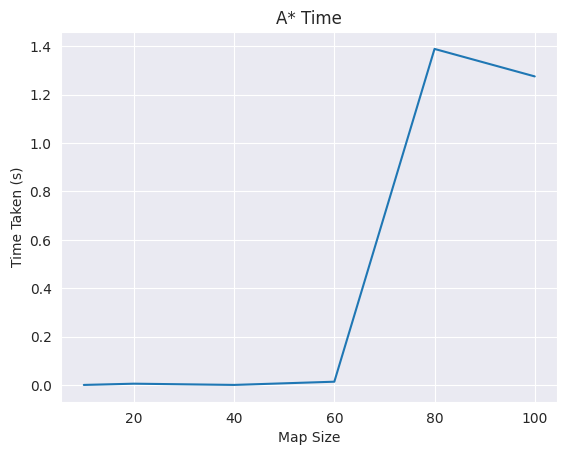

In [10]:
agg = astar_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("A* Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

/tmp/ipykernel_358217/1886498706.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = dijkstra_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Time Taken (s)')

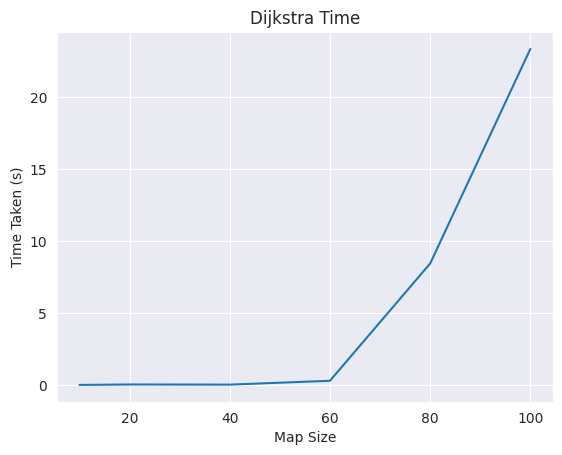

In [11]:
agg = dijkstra_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("Dijkstra Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

/tmp/ipykernel_358217/3908284060.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = dfs_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Time Taken (s)')

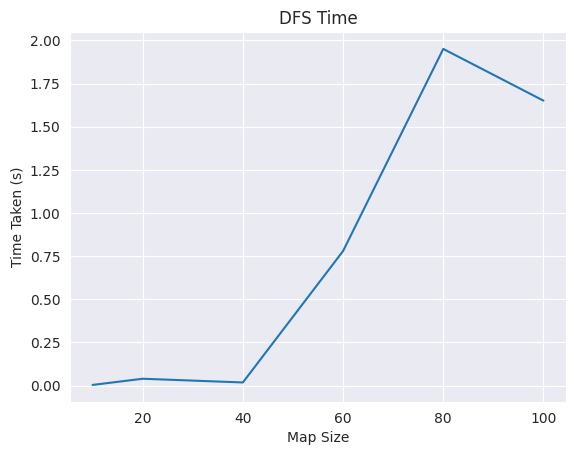

In [12]:
agg = dfs_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("DFS Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

/tmp/ipykernel_358217/417163350.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = rrt_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Time Taken (s)')

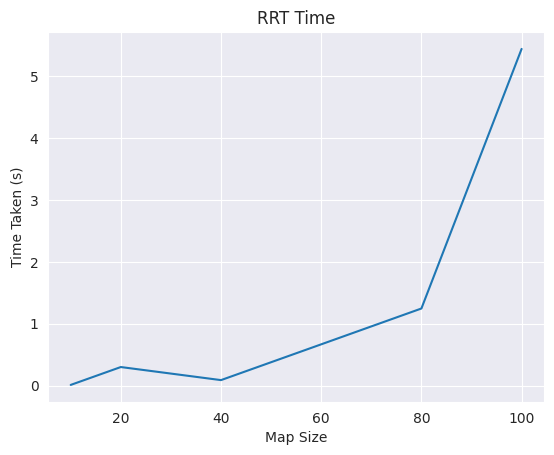

In [13]:
agg = rrt_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("RRT Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

/tmp/ipykernel_358217/3785746358.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = rrt_star_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Time Taken (s)')

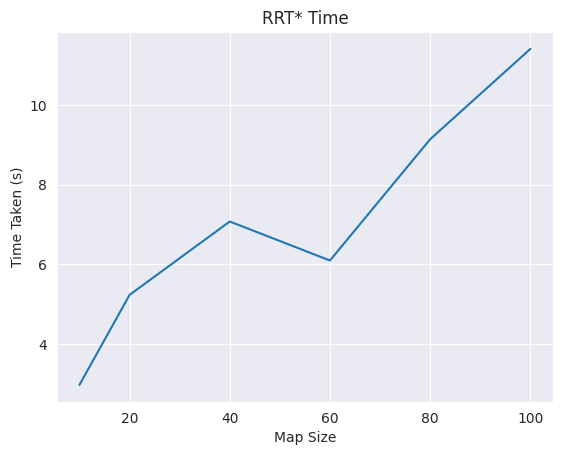

In [14]:
agg = rrt_star_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="time_taken").set_title("RRT* Time")
plt.xlabel("Map Size")
plt.ylabel("Time Taken (s)")

/tmp/ipykernel_358217/3863908096.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = astar_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Node Visited')

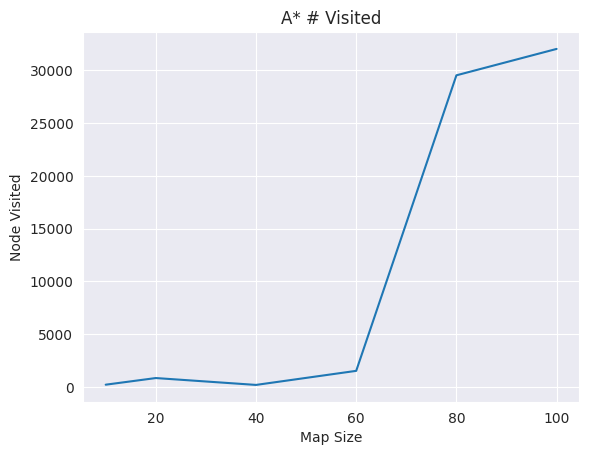

In [15]:
agg = astar_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="n_visited").set_title("A* # Visited")
plt.xlabel("Map Size")
plt.ylabel("Node Visited")

/tmp/ipykernel_358217/1437018314.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = dijkstra_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Node Visited')

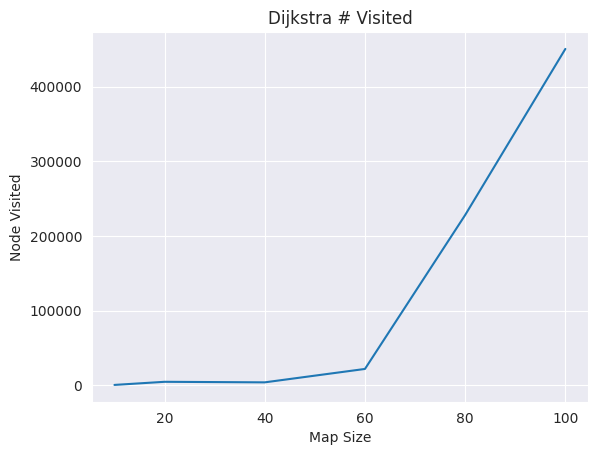

In [16]:
agg = dijkstra_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="n_visited").set_title("Dijkstra # Visited")
plt.xlabel("Map Size")
plt.ylabel("Node Visited")

/tmp/ipykernel_358217/2481146223.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = dfs_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Node Visited')

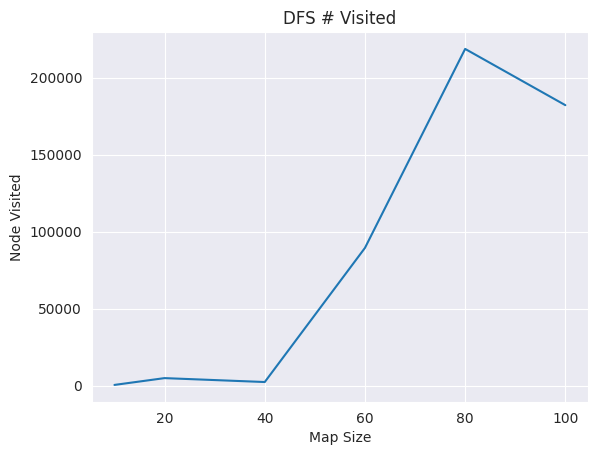

In [17]:
agg = dfs_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="n_visited").set_title("DFS # Visited")
plt.xlabel("Map Size")
plt.ylabel("Node Visited")

/tmp/ipykernel_358217/2669828722.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = rrt_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Node Visited')

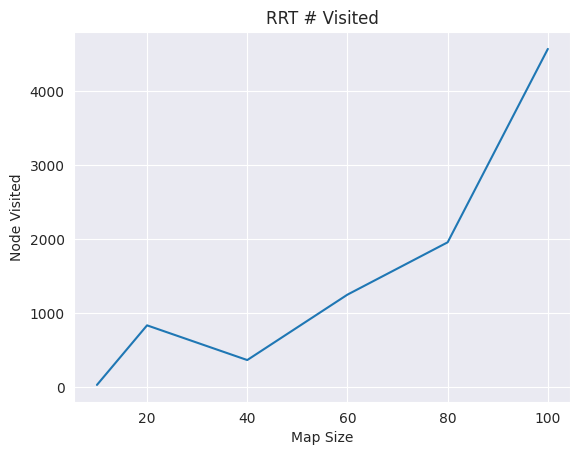

In [18]:
agg = rrt_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="n_visited").set_title("RRT # Visited")
plt.xlabel("Map Size")
plt.ylabel("Node Visited")

/tmp/ipykernel_358217/4167379284.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg = rrt_star_time_df.groupby(by="size").mean()


Text(0, 0.5, 'Node Visited')

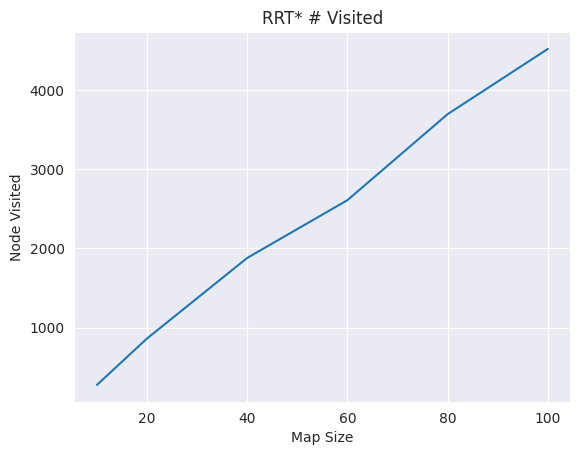

In [19]:
agg = rrt_star_time_df.groupby(by="size").mean()
ax = sns.lineplot(data=agg, x="width", y="n_visited").set_title("RRT* # Visited")
plt.xlabel("Map Size")
plt.ylabel("Node Visited")

In [82]:
# agg = dijkstra_time_df
merged_df = pd.concat([astar_time_df,dijkstra_time_df,dfs_time_df,rrt_time_df,rrt_star_time_df]).reset_index()
merged_df = merged_df[merged_df['solved']==True]

Text(0.5, 1.0, 'Log Path Length vs Map Size')

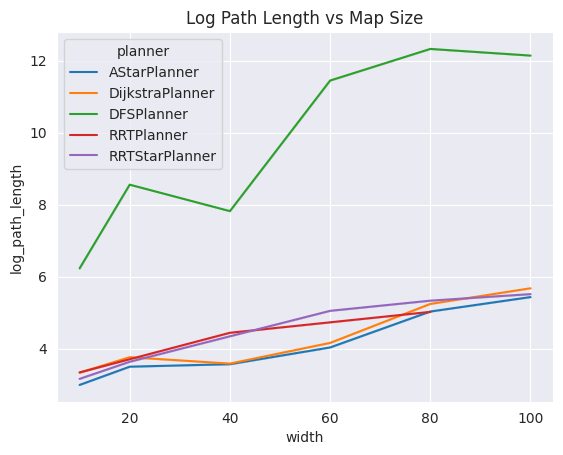

In [83]:
merged_df['log_path_length'] = np.log(merged_df['path_length'])
sns.lineplot(data=merged_df, x='width', y='log_path_length', hue='planner')
plt.title("Log Path Length vs Map Size")

Text(0.5, 1.0, 'Path Length vs Map Size')

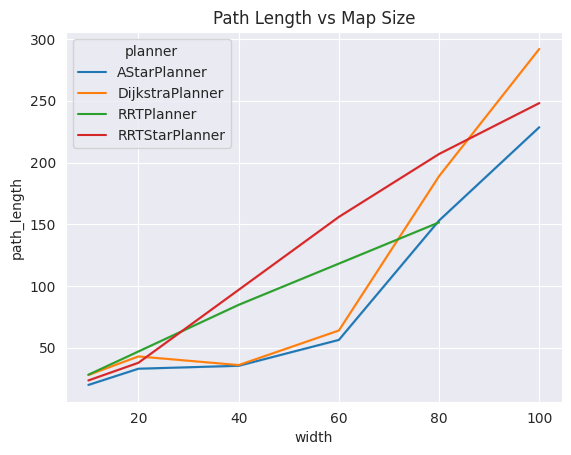

In [84]:
no_dfs = merged_df[merged_df['planner'] != 'DFSPlanner']
sns.lineplot(data=no_dfs, x='width', y='path_length', hue='planner')
plt.title("Path Length vs Map Size")

Text(0.5, 1.0, 'Time Taken vs Map Size')

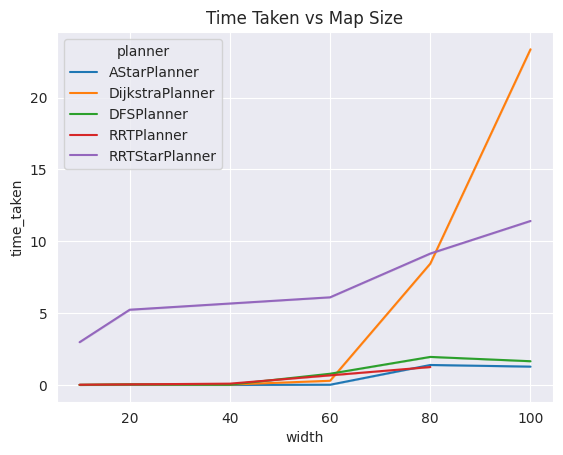

In [85]:
sns.lineplot(data=merged_df, x='width', y='time_taken', hue='planner')
plt.title("Time Taken vs Map Size")

Text(0.5, 1.0, '# Visited vs Map Size')

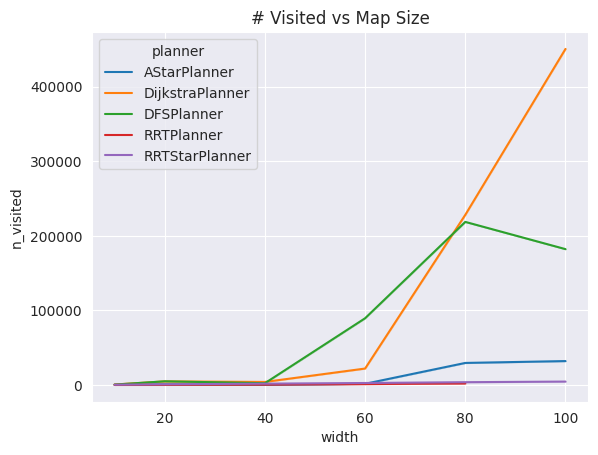

In [86]:

sns.lineplot(data=merged_df, x='width', y='n_visited', hue='planner')
plt.title("# Visited vs Map Size")
# merged_df

Text(0.5, 1.0, 'Visited Ratio vs Map Size')

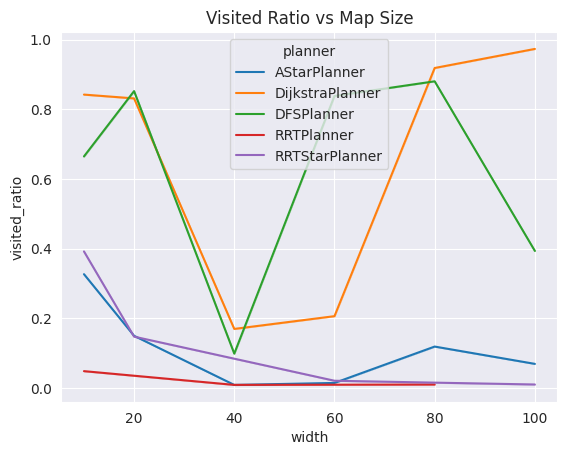

In [87]:

sns.lineplot(data=merged_df, x='width', y='visited_ratio', hue='planner')
plt.title("Visited Ratio vs Map Size")

In [88]:
merged_df[merged_df['planner'] == 'RRTStarPlanner']

,index,seed,solved,path_length,n_visited,n_free,width,length,height,size,free_ratio,visited_ratio,planner,time_taken,log_path_length
480,0,0,True,23.559920,276,704,10,10,10,1000,0.704000,0.392045,RRTStarPlanner,2.940969,3.159547
481,1,0,True,37.888799,863,5855,20,20,20,8000,0.731875,0.147395,RRTStarPlanner,5.288679,3.634656
483,3,0,True,155.992485,2611,125902,60,60,60,216000,0.582880,0.020738,RRTStarPlanner,6.082119,5.049808
484,4,0,True,206.942324,3698,242087,80,80,80,512000,0.472826,0.015276,RRTStarPlanner,9.166883,5.332440
485,5,0,True,248.144490,4522,453383,100,100,100,1000000,0.453383,0.009974,RRTStarPlanner,11.433345,5.514011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,114,19,True,23.559920,276,704,10,10,10,1000,0.704000,0.392045,RRTStarPlanner,2.969885,3.159547
595,115,19,True,37.888799,863,5855,20,20,20,8000,0.731875,0.147395,RRTStarPlanner,5.187219,3.634656
597,117,19,True,155.992485,2611,125902,60,60,60,216000,0.582880,0.020738,RRTStarPlanner,6.090876,5.049808
598,118,19,True,206.942324,3698,242087,80,80,80,512000,0.472826,0.015276,RRTStarPlanner,9.142891,5.332440


In [20]:
bmap, src, target = Scenario.get(0, ScenarioSize.L)
rrt_planner = RRTStarPlanner(bmap, max_steps=5000)
solved, visited, path = rrt_planner.plan(src, target)
solved

True